# Landslide susceptibility

© 2024 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/EAFIT_slope_stability/blob/main/notebooks/01_cond_factors/landslide_susceptibility.ipynb).

<!-- This notebook was developed following the procedure by [Gonzalez (1999)](https://www.scg.org.co/wp-content/uploads/2021/08/ESTIMATIVOS-DE-PARAMETROS-DE-RESISTENCIA-CON-SPT-1.pdf). -->

## Required modules and global setup for plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit, minimize
from sklearn.metrics import roc_curve, roc_auc_score
from ipywidgets import widgets as wgt
from IPython import get_ipython
from IPython.display import display

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    from subprocess import run
    run('pip install ipympl', shell=True);
    from google.colab import output, files
    output.enable_custom_widget_manager()
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename

# Figures setup
%matplotlib widget
# plt.style.use("default")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "DejaVu Serif",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)


## Example

### Reading the input data

In [2]:
testing_data = True  # Set to False to use the GUI to load the data from an external file

In [3]:
# Tabulated data
if testing_data:
    url = "https://raw.githubusercontent.com/eamontoyaa/data4testing/main/susceptibility/"
    df = pd.read_csv(f"{url}susc_data.csv")
elif testing_data is False and 'google.colab' in str(get_ipython()):
    file = files.upload()
    df = pd.read_csv(list(file.values())[0])
else:  # GUI for file selection from local machine if not in CoLab
    tk.Tk().withdraw() # part of the import if you are not using other tkinter functions
    file = askopenfilename()
    df = pd.read_csv(file)
df

,Elevation,Aspect,Slope,Curvature,Flow acc,TPI,Roads,Rivers,ID,Landslides,...,Class [D2],Wij [E],Wij [S],Wij [A],Wij [C],Wij [FA],Wij [TP],Wij [D1],Wij [D2],ISTCU
0,735.72,283.50,12.82,-0.00564,112.24,0.16,56.57,40.00,1,yes,...,p1,0.167800,0.046295,0.068001,-0.009677,0.180951,-0.003212,-0.023337,0.210228,0.637049
1,732.19,276.19,13.21,-0.00230,105.33,0.41,40.00,63.25,2,yes,...,p2,0.167800,0.046295,0.077230,-0.031836,0.180951,-0.030696,-0.023337,0.161023,0.547430
2,736.51,278.57,12.97,-0.00496,85.72,-0.03,40.00,56.57,3,yes,...,p2,0.167800,0.046295,0.077230,-0.009677,0.105652,-0.003212,-0.023337,0.161023,0.521775
3,741.37,280.63,12.25,-0.01203,82.64,0.69,28.28,44.72,4,yes,...,p2,0.167800,0.046295,0.068001,-0.068639,0.105652,-0.033090,-0.023337,0.161023,0.423705
4,745.37,288.94,8.89,-0.00436,72.31,1.05,20.00,40.00,5,yes,...,p1,0.167800,0.032614,0.068001,-0.009677,0.105652,-0.033090,-0.113922,0.210228,0.427606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,831.93,225.89,7.47,-0.03553,2.60,0.82,240.83,672.31,2496,no,...,p8,0.022721,-0.059663,-0.016024,-0.198733,-0.325177,-0.033090,0.040095,0.073605,-0.496267
2496,833.36,192.59,7.24,-0.03034,2.37,1.06,226.27,680.29,2497,no,...,p8,0.022721,-0.059663,-0.045616,-0.198733,-0.325177,-0.033090,0.040095,0.073605,-0.525859
2497,833.03,174.95,8.69,-0.00403,4.16,0.41,212.60,688.77,2498,no,...,p8,0.022721,0.032614,-0.045616,-0.009677,-0.074792,-0.030696,0.040095,0.073605,0.008254
2498,832.50,180.81,9.59,0.01264,7.15,-0.21,200.00,697.71,2499,no,...,p8,0.022721,0.032614,-0.045616,0.075127,-0.140441,0.094589,0.025357,0.073605,0.137956


### Convert landslide field from string to binary

In [4]:
df['Landslides_bin'] = df['Landslides'].apply(lambda x: 1 if x == 'yes' else 0)
df

,Elevation,Aspect,Slope,Curvature,Flow acc,TPI,Roads,Rivers,ID,Landslides,...,Wij [E],Wij [S],Wij [A],Wij [C],Wij [FA],Wij [TP],Wij [D1],Wij [D2],ISTCU,Landslides_bin
0,735.72,283.50,12.82,-0.00564,112.24,0.16,56.57,40.00,1,yes,...,0.167800,0.046295,0.068001,-0.009677,0.180951,-0.003212,-0.023337,0.210228,0.637049,1
1,732.19,276.19,13.21,-0.00230,105.33,0.41,40.00,63.25,2,yes,...,0.167800,0.046295,0.077230,-0.031836,0.180951,-0.030696,-0.023337,0.161023,0.547430,1
2,736.51,278.57,12.97,-0.00496,85.72,-0.03,40.00,56.57,3,yes,...,0.167800,0.046295,0.077230,-0.009677,0.105652,-0.003212,-0.023337,0.161023,0.521775,1
3,741.37,280.63,12.25,-0.01203,82.64,0.69,28.28,44.72,4,yes,...,0.167800,0.046295,0.068001,-0.068639,0.105652,-0.033090,-0.023337,0.161023,0.423705,1
4,745.37,288.94,8.89,-0.00436,72.31,1.05,20.00,40.00,5,yes,...,0.167800,0.032614,0.068001,-0.009677,0.105652,-0.033090,-0.113922,0.210228,0.427606,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,831.93,225.89,7.47,-0.03553,2.60,0.82,240.83,672.31,2496,no,...,0.022721,-0.059663,-0.016024,-0.198733,-0.325177,-0.033090,0.040095,0.073605,-0.496267,0
2496,833.36,192.59,7.24,-0.03034,2.37,1.06,226.27,680.29,2497,no,...,0.022721,-0.059663,-0.045616,-0.198733,-0.325177,-0.033090,0.040095,0.073605,-0.525859,0
2497,833.03,174.95,8.69,-0.00403,4.16,0.41,212.60,688.77,2498,no,...,0.022721,0.032614,-0.045616,-0.009677,-0.074792,-0.030696,0.040095,0.073605,0.008254,0
2498,832.50,180.81,9.59,0.01264,7.15,-0.21,200.00,697.71,2499,no,...,0.022721,0.032614,-0.045616,0.075127,-0.140441,0.094589,0.025357,0.073605,0.137956,0


### Display Receiver Operating Characteristic (ROC) curves

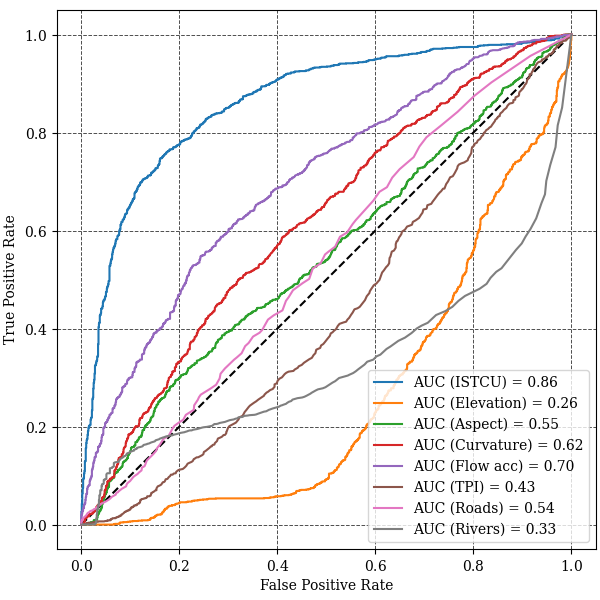

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6), layout='constrained')
plt.plot([0, 1], [0, 1], 'k--')


fpr, tpr, thresholds = roc_curve(df['Landslides_bin'], df['ISTCU'])  # Calculate the ROC curve
auc_score = roc_auc_score(df['Landslides_bin'], df['ISTCU'])  # Calculate the AUC score
ax.plot(fpr, tpr, label=f'AUC (ISTCU) = {auc_score:.2f}')

# fpr_slope, tpr_slope, thresholds_slope = roc_curve(df['Landslides_bin'], df['Slope'])  # Calculate the ROC curve
# auc_score_slope = roc_auc_score(df['Landslides_bin'], df['Slope'])  # Calculate the AUC score
# ax.plot(fpr_slope, tpr_slope, label=f'AUC (Slope) = {auc_score_slope:.2f}')

for field in ['Elevation', 'Aspect', 'Curvature', 'Flow acc', 'TPI', 'Roads', 'Rivers']:
    fpr, tpr, thresholds = roc_curve(df['Landslides_bin'], df[field])  # Calculate the ROC curve
    auc_score = roc_auc_score(df['Landslides_bin'], df[field])  # Calculate the AUC score
    ax.plot(fpr, tpr, label=f'AUC ({field}) = {auc_score:.2f}')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_aspect('equal')
ax.legend()
ax.grid(True, color='0.3', ls='--', lw=0.7)

fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'bottom'
plt.show()